In [ ]:
import os
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Conv2D, Multiply
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from google.colab import files


In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle

# Upload Kaggle API key
files.upload()

# Download and unzip the dataset
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0


In [ ]:
# Set data directory
data_dir = "/content"

# Load metadata
df_meta = pd.read_csv(os.path.join(data_dir, "HAM10000_metadata.csv"))

# Select only the required classes: 'df', 'vasc', 'akiec'
selected_classes = ['df', 'vasc', 'akiec']
df_meta = df_meta[df_meta['dx'].isin(selected_classes)].reset_index(drop=True)

# Collect all image paths from both directories
image_paths = glob('/content/HAM10000_images_part_1/*.jpg') + glob('/content/HAM10000_images_part_2/*.jpg')

# Create a dictionary mapping image IDs to their full paths
imageid_path_dict = {
    os.path.splitext(os.path.basename(path))[0]: path
    for path in image_paths
}

# Map image paths to the metadata dataframe
df_meta['path'] = df_meta['image_id'].map(imageid_path_dict.get)

# Check for missing paths
if df_meta['path'].isnull().any():
    print("Some images are missing from the provided directories!")
    missing_ids = df_meta[df_meta['path'].isnull()]['image_id'].tolist()
    print(f"Missing image IDs: {missing_ids}")

# Map categorical labels to numeric values
label_mapping = {label: idx for idx, label in enumerate(selected_classes)}
df_meta['label'] = df_meta['dx'].map(label_mapping)

# Split dataset into training and validation sets
train_df, val_df = train_test_split(df_meta, stratify=df_meta['label'], test_size=0.2, random_state=42)

# Augmentation parameters

In [ ]:
# Augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to augment images
augmented_dir = os.path.join(data_dir, "augmented_images")
os.makedirs(augmented_dir, exist_ok=True)

def augment_and_save_images(df, imgs_to_generate=500):
    augmented_data = []

    for class_label in df['label'].unique():
        class_data = df[df['label'] == class_label]
        img_count = len(class_data)

        for i in range(imgs_to_generate):
            img_path = class_data.iloc[i % img_count]['path']
            img = tf.keras.utils.load_img(img_path, target_size=(299, 299))
            img_array = tf.keras.utils.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)

            augmented_images = datagen.flow(img_array, batch_size=1)
            for aug_img in augmented_images:
                save_path = os.path.join(augmented_dir, f"{class_label}_{i}.jpg")
                tf.keras.preprocessing.image.save_img(save_path, aug_img[0])
                augmented_data.append((save_path, class_label))
                break

    return pd.DataFrame(augmented_data, columns=['path', 'label'])

In [ ]:
# Augment training data
augmented_train_df = augment_and_save_images(train_df)

# Combine augmented data with original training data
train_df_combined = pd.concat([train_df[['path', 'label']], augmented_train_df], ignore_index=True)

# Convert 'label' column to string
train_df_combined['label'] = train_df_combined['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

In [ ]:
# Prepare data generators for training and validation
train_gen = datagen.flow_from_dataframe(
    train_df_combined,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

val_gen = ImageDataGenerator().flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

Found 1967 validated image filenames belonging to 3 classes.
Found 117 validated image filenames belonging to 3 classes.


In [ ]:
# Build model with VGG16 + attention
input_tensor = Input(shape=(224, 224, 3))
base_model = VGG16(include_top=False, input_tensor=input_tensor, weights='imagenet')
base_model.trainable = False

x = base_model.output

# Attention mechanism
attn = Conv2D(512, kernel_size=1, activation='relu')(x)
attn = Conv2D(1, kernel_size=1, activation='sigmoid')(attn)
x = Multiply()([x, attn])

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(len(selected_classes), activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 15,109,956 (57.64 MB)

 Trainable params: 395,268 (1.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define model checkpoint
checkpoint_path = os.path.join(data_dir, "vgg16_attention_best_model.keras")
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Load training history (or initialize a new one if no history exists)
history_file = 'vgg16_attention_train_history.pkl'

def load_history():
    try:
        with open(history_file, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        return {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

# Training parameters
total_epochs = 100
epochs_per_session = 100
initial_epoch = len(load_history()['accuracy'])  # Resume from the last saved epoch

# Incremental training
while initial_epoch < total_epochs:
    print(f"\nStarting training from epoch {initial_epoch} to {initial_epoch + epochs_per_session}")

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=initial_epoch + epochs_per_session,
        initial_epoch=initial_epoch,
        callbacks=[checkpoint, reduce_lr]
    )

    prev_history = load_history()
    for key in history.history:
        if key in prev_history:
            prev_history[key].extend(history.history[key])
        else:
            prev_history[key] = history.history[key]

    with open(history_file, 'wb') as f:
        pickle.dump(prev_history, f)

    initial_epoch += epochs_per_session
    print(f"Completed {initial_epoch} epochs. Training progress saved.\n")

# Final evaluation
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Final Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Starting training from epoch 0 to 100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.3443 - loss: 3.5576
Epoch 1: val_loss improved from inf to 1.60224, saving model to /content/vgg16_attention_best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 64s 734ms/step - accuracy: 0.3448 - loss: 3.5448 - val_accuracy: 0.5641 - val_loss: 1.6022 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.3737 - loss: 1.4613
Epoch 2: val_loss improved from 1.60224 to 1.16670, saving model to /content/vgg16_attention_best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 52s 495ms/step - accuracy: 0.3739 - loss: 1.4595 - val_accuracy: 0.5641 - val_loss: 1.1667 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.3820 - loss: 1.1794
Epoch 3: val_loss improved from 1.16670 to 1.09205, saving model to /content/vgg16_attention_best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 490ms/step - accuracy: 0.3820 - loss: 1.1791 - val_accuracy: 0.5641 - val_loss: 1.0921 - learning_

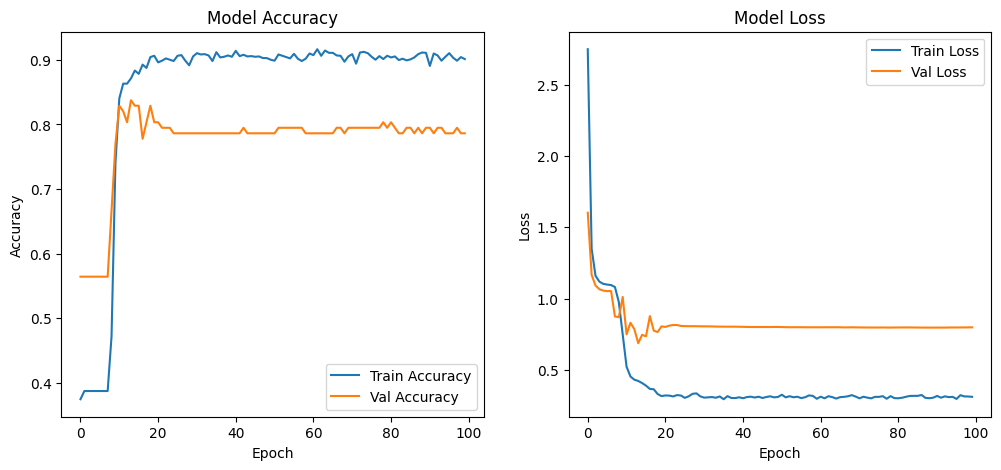

In [ ]:
# Plot the final history
with open(history_file, 'rb') as f:
    final_history = pickle.load(f)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(final_history['accuracy'], label='Train Accuracy')
plt.plot(final_history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_history['loss'], label='Train Loss')
plt.plot(final_history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()